In [17]:
# ============================================================
# Notebook setup
# ============================================================
%load_ext autoreload
%autoreload 2

# Retrain or use existing models
use_cached_weights=True

# Control figure size
figsize=(14, 3.5)
figsize_narrow=(14, 2.5)

import numpy as np
from util import util
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generalizing DFL

Which is where we reap the most benefits

## Two-Stage Stochastic Optimization

**If DFL targets one-stage stochastic optimization, could we do _two-stage_?**

<center><img src="assets/holiday-suitcase.jpg" width=50%></center>

* For example, in _first stage_ we decide what to pack in our suitcase
* ...During the trip, we may realize we have _forgotten something_
* ...And we need to _spend money_ to buy the missing stuff

## Two-Stage Stochastic Optimization

**If DFL targets one-stage stochastic optimization, could we do _two-stage_?**

Two-stage problems are among the most interesting in stochastic optimization

* They involve making a set of decisions now
* Then observing how uncertainty unfolds
* ...And making a second set of decisions

The former are called _first-stage decisions_, the latter _recourse actions_

**Here's an example we will use for this topic**

Say we need to _secure a supply of resources_

* First, we make contracts with primary suppliers to minimize costs
* If there are unexpected setbacks (e.g. insufficient yields)
* ...Then we can buy what we lack from another source, but at a higher cost

## Two-Stage Stochastic Optimization

**Let's define two-stage stochastic optimization problems (2s-SOP) formally:**

$$
\text{argmin}_{z} \left\{f(z) + \mathbb{E}_{y \sim P(Y \mid x)} \left[\min_{z^"} r(z^", z, y)\right]  \mid z \in F, z^" \in F^"(z, y) \right\}
$$

* $Y$ represents the uncertain information
* $z$ is the vector of _first stage decisions_
* $F$ is the feasible space for the first stage
* $z^"$ is the vector of _recourse actions_
* $z^"$ is not fixed: it can change for every sampled $y$
* The set of feasible recourse actions $F^"(z, y)$ also changes for every $y$
* $f$ is the immediate cost function, $r$ is the cost of the recourse actions

## A Simple Example

**We will consider this simple problem**

...Which is based on our previous supply planning example:

$$\begin{align}
\text{argmin}_{z}\ & c^T z + \mathbb{E}_{y \sim P(Y \mid x)} \left[\min_{z^"} c^" z^" \right] \\
\text{subject to: } & y^T z + z^" \geq y_{min} \\
             & z \in \{0,1\}^n, z^" \in \mathbb{N}_0
\end{align}$$

* $z_j = 1$ iff we choose then $h$-th supply contract
* $c_j$ is the cost of the $j$-th contract
* $y_j$ is the yield of the $j$-th contract, which is uncertaint
* $y_{min}$ is the minimum total yield, which is known
* $z^"$ is the number of units we buy at cost $c^"$ to satisfy the yield  requirement

## Scenario Based Approach

**Classical solution approaches for 2s-SOP are scenario based**

We start by sampling a finite set of $N$ values from $P(Y \mid x)$

$$\begin{align}
\text{argmin}_{z} \text{min}_{z^"}\ &  c^T z + \frac{1}{N} c^" z^"_k \\
\text{subject to: } & y^T z + z^"_k \geq y_{min} & \forall k = 1..N\\
             & z \in \{0,1\}^n \\
             & z^"_k \in \mathbb{N}_0 & \forall k = 1..N
\end{align}$$

Then we build different recourse action variables for each scenario

* ...We define the feasible sets via constraints
* ...And we use the Sample Average Approximation to estimate the expectation

**The method is effective, but also computationally expensive**

## DFL for 2s-SOP

**Could we tackle 2s-SOP with DFL?**

As a recap, our DFL training problem is:

$$
\theta^* = \text{argmin}_\theta \left\{\mathbb{E}_{(x, y) \sim P(X, Y)}[\text{regret}(y, \hat{y})] \mid \hat{y} = h(x; \theta) \right\}
$$

With:

$$
\text{regret}(y, \hat{y}) = y^T z^*(\hat{y}) - y^T z^*(y)
$$

And:

$$
z^*(y) = \text{argmin}_{z} \{y^T z \mid z \in F\}
$$

## DFL for 2s-SOP

**With the same transformations used in the one-stage case, we get:**

$$
\theta^* = \text{argmin}_\theta \left\{\mathbb{E}_{y \sim P(Y \mid x)}[y^T z^*(\hat{y})] \mid \hat{y} = h(x; \theta), z^*(\hat{y}) \in F \right\}
$$

**Now, say we had a DFL approch that could deal with _any function $g(z, y)$_**

* In this case $y$ would be a vector of uncertain parameters (not necessarily costs)
* The function should compute the equivalent of $y^T z^*(\hat{y})$
* ...I.e. the true cost of the solution computed for the estimate costs

**Under this conditions, at training time we could solve:**

$$
\theta^* = \text{argmin}_\theta \left\{ \mathbb{E}_{y \sim P(Y \mid x)}[g(z^*(\hat{y}), y)] \mid \hat{y} = h(x; \theta), z^*(\hat{y}) \in F \right\}
$$

It would still be DFL, just a bit more general

## DFL for 2s-SOP

**At this point, let's choose:**

$$
g(z, y) = \min_{z^"} \left\{ f(z) + r(z^", z, y) \mid z^" \in F^"(z, y) \right\}
$$

* For a given solution $z$, $g(z, y)$ computes the best possible objective
* ...Assuming that the value of the parameters is $y$

**By substituting in the training formulation we get:**

$$\begin{align}
& \text{argmin}_{\theta}\ f(z^*(\hat{y})) + \mathbb{E}_{y \sim P(Y \mid x)} \left[\min_{z^"} r(z^", z^*(\hat{y}), y)\right] \\
& \text{subject to: } \hat{y} = h(x; \theta), z^*(\hat{y}) \in F, z^" \in F^"(z, y)
\end{align}$$

...Which can definitely be used for 2s-SOP problems!

## Grouding the Approach

**We can ground the approach by relying on the scenario-based formulation**

In our example problem, we compute $z^*(y)$ by solving:

$$\begin{align}
z^*(y) = \text{argmin}_{z} \text{min}_{z^"} &  c^T z + c^" z^"_k \\
\text{subject to: } & y^T z + z^"_k \geq y_{min} &\\
             & z \in \{0,1\}^n \\
             & z^"_k \in \mathbb{N}_0 &
\end{align}$$

And we define $g(z, y)$ as:

$$\begin{align}
g(z, y) = \text{min}_{z^"}\ &  c^T z + c^" z^"_k \\
\text{subject to: } & y^T z + z^"_k \geq y_{min} &\\
             & z^"_k \in \mathbb{N}_0 &
\end{align}$$

## Overview and Properties

**Intuitively, the approach works as follows**

* We observe $x$ and we compute $\hat{y}$
* We compute $z^*(\hat{y})$ by solving a scenario problem
* We compute $g(z^*(\hat{y}), y)$ by solving a scenario problem with fixed $z$ values

...And we end up minimizing the expected cost of the 2s-SOP

**We have 1 restriction and 3 "superpowers" w.r.t. the classical approach**

* The restriction: we control $z^*$ only through $\theta$
* Superpower 1: we are not restricted to a single $x$
* Superpower 2: works with any distribution
* Superpower 3: at inference time, we always consider _a single scenario_

## Scalable Two-stage Stochastic Optimization

**The last advantage is _massive_**

The weakest point of classical 2s-SOP approach is scalability

* Multiple scenarios are required to obtain good results
* ...But they also add more variables

With NP-hard problem, the solution time can grow exponentially

**With this approach, the computational cost is all at training time**

* It can even be lower, since you always deal with single scenarios
* There are alternatives, such as [1], where ML is used to estimate the recourse
* ...These have their own pros and cons

<small><i>
[1] Dumouchelle, Justin, et al. "Neur2sp: Neural two-stage stochastic programming." arXiv preprint arXiv:2205.12006 (2022).
</i></small>

## The Elephant in the Room

**So far, so good, but how to we make $g(z, y)$ differentiable?**

There are a few alternatives, all with limitations:

* The approach from [1] handles parameters in the problem constraints
  - It is based on the idea of differencing the recourse action
  - ...But it is (mostly) restricted to 1D packing problems
* The approach from [2] can be used for 2s-SOP with a stretch
  - It based on idea of embedding a MILP solver in ML
  - ...But it's semantic does not fully align with 2s-SOP

**Here, we will see a different technique**

<small><i>
[1] Hu, X., Lee, J. C. H., and Lee, J. H. M. Predict+optimize for packing and covering lps with unknown parameters
in constraints. CoRR, abs/2209.03668, 2022. doi: 10. 48550/arXiv.2209.03668.<br>
[2] Paulus, Anselm, et al. "Comboptnet: Fit the right np-hard problem by learning integer programming constraints." International Conference on Machine Learning. PMLR, 2021.
</i></small>

## Looking Back at SPO

**Let's look again at the regret loss for our original toy example** 

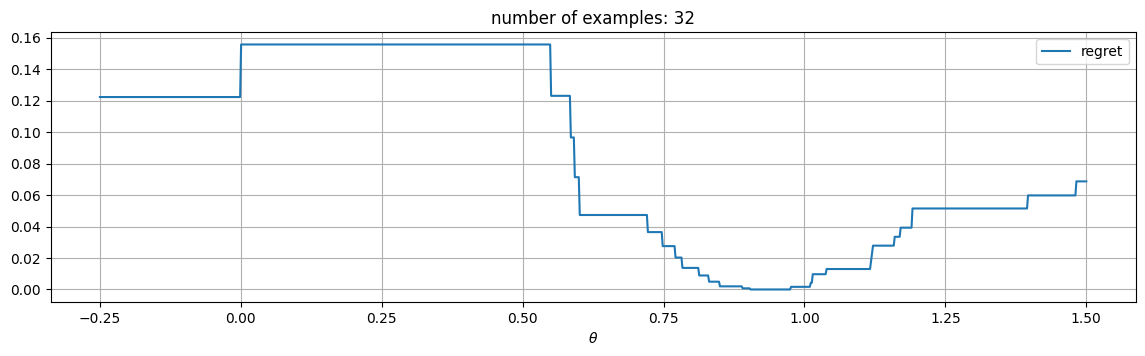

In [18]:
util.draw_loss_landscape(losses=[util.RegretLoss()], model=1, seed=42, batch_size=32, figsize=figsize)

* It is non-differentiable at places, and flat almost everywhere
* Can we think of another way to address these issues?

## Looking Back at SPO

**If we could act on this function itself, a simple solution would be _smoothing_** 

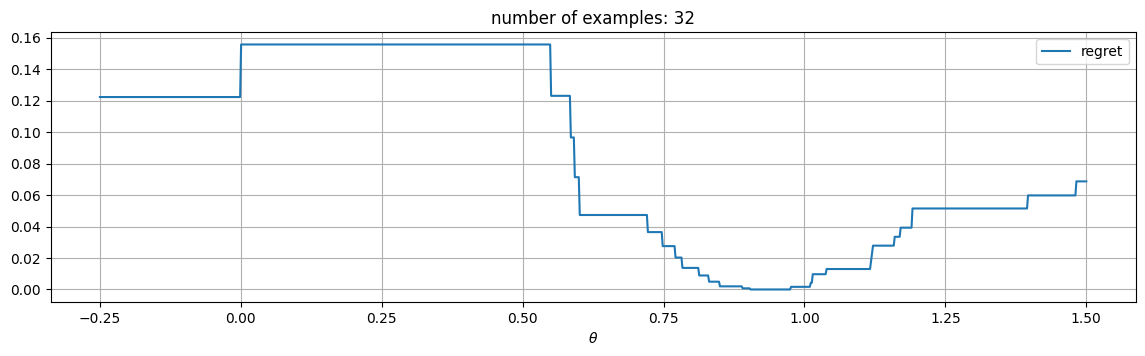

In [19]:
util.draw_loss_landscape(losses=[util.RegretLoss()], model=1, seed=42, batch_size=32, figsize=figsize)

* We could think of computing a convolution with a Gaussian kernel
* It would be like applying a Gaussian filter to an image

## Stochastic Smoothing

**But how can we do it through an optimization problem?**

A viable approach is using stochastic smoothing

* Rather than learning a point estimator $h(x; \theta)$
* We learn a _stochastic estimator_ s.t. $\hat{y} \sim \mathcal{N}(h(x; \theta), \sigma)$

**Intuitively:**

* We still use a point estimator, but to predict _a vector of means_
* Then we sample $\hat{y}$ from a normal distribution having the specified mean
* ...And a fixed standard deviation

We end up smoothing over $\hat{y}$ rather than over $\theta$

**But it's very close to what we wanted to do!**

## Stochastic Smoothing

**Let's see how it works on our toy example**

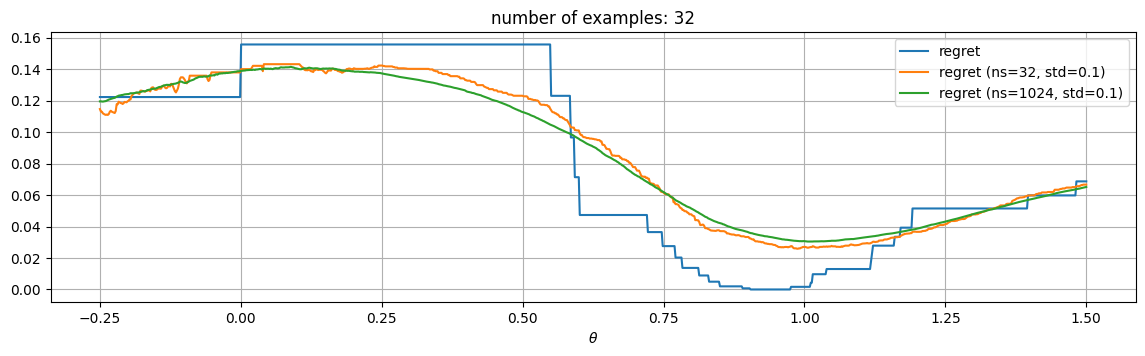

In [20]:
util.draw_loss_landscape(losses=[util.RegretLoss(), util.RegretLoss(smoothing_samples=32, smoothing_std=0.1), util.RegretLoss(smoothing_samples=1024, smoothing_std=0.1)], model=1, seed=42, batch_size=32, figsize=figsize)

* It's a stochastic approach, some some noise is to be expected
* Using _more samples_ leads to better smoothing

## Stochastic Smoothing

**We can control the smoothing level by adjusting $\sigma$**

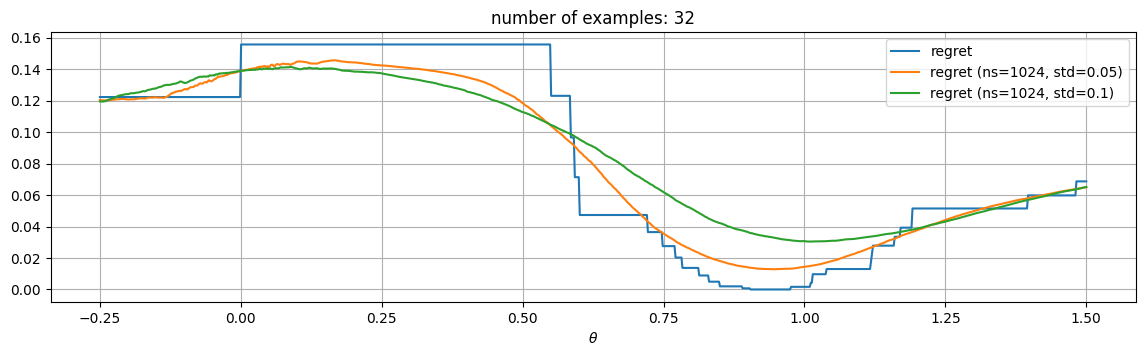

In [21]:
util.draw_loss_landscape(losses=[util.RegretLoss(), util.RegretLoss(smoothing_samples=1024, smoothing_std=0.05), util.RegretLoss(smoothing_samples=1024, smoothing_std=0.1)], model=1, seed=42, batch_size=32, figsize=figsize)

* Larger $\sigma$ value remove flat sections better
* ...But also cause _a shift_ in the position of the optimum

## Score Function Gradient Estimation

**How does that help us?**

Normally, the DFL loss looks like this:

$$
L_{DFL}(\theta) = \mathbb{E}_{(x, y) \sim P(X, Y)}[\text{regret}(y, \hat{y})]
$$

When we apply stochastic smoothing, it turns into:

$$
\tilde{L}_{DFL}(\theta) = \mathbb{E}_{(x, y) \sim P(X, Y), \hat{y} \sim \mathcal{N}(h(x, \theta))}[\text{regret}(y, \hat{y})]
$$

**The expectation is now computed on $x$, $y$, _and $\hat{y}$_**

* We can use a sample average to handle the expectation on $x$ and $y$
* ...But if we do it on $\hat{y}$ we are left with nothing differentiable

## Score Function Gradient Estimation

**So we expand the last expectation on $\hat{y}$:**

$$
\tilde{L}_{DFL}(\theta) = \mathbb{E}_{(x, y) \sim P(X, Y)}\left[\int_{\hat{y}} \text{regret}(y, \hat{y}) p(\hat{y}, \theta) d\hat{y} \right]
$$

* $\text{regret}(y, \hat{y})$ cannot be differentiated, since $\hat{y}$ is a fixed sample in this setup
* However, the probability $p(\hat{y}, \theta)$ can! It's just a Normal PDF

Now, we just need a way to handle the integral

**We do it by _focusing on the gradient_**

Due to linearity of expectation and integration, this is given by:

$$
\nabla \tilde{L}_{DFL}(\theta) = \mathbb{E}_{(x, y) \sim P(X, Y)}\left[\int_{\hat{y}} \text{regret}(y, \hat{y}) \nabla_\theta p(\hat{y}, \theta) d\hat{y} \right]
$$

## Score Function Gradient Estimation

**Let's consider again the expression we have obtained**

$$
\nabla \tilde{L}_{DFL}(\theta) = \mathbb{E}_{(x, y) \sim P(X, Y)}\left[\int_{\hat{y}} \text{regret}(y, \hat{y}) \nabla_\theta p(\hat{y}, \theta) d\hat{y} \right]
$$

Since that $\log'(f(x)) = 1/x f'(x)$, we can rewrite the formula as:

$$
\nabla \tilde{L}_{DFL}(\theta) = \mathbb{E}_{(x, y) \sim P(X, Y)}\left[\int_{\hat{y}} \text{regret}(y, \hat{y}) \color{red}{p(\hat{y}, \theta)\nabla_\theta \log p(\hat{y}, \theta)}d\hat{y} \right]
$$

Now, the integral is again an expectation, so we have:

$$
\nabla \tilde{L}_{DFL}(\theta) = \mathbb{E}_{(x, y) \sim P(X, Y), \hat{y} \sim \mathcal{N}(h(x, \theta), \sigma)}\left[\text{regret}(y, \hat{y}) \nabla_\theta \log p(\hat{y}, \theta) \right]
$$

## Score Function Gradient Estimation

**Finally, we can use a sample average to approximate both expectations:**

$$
\nabla \tilde{L}_{DFL}(\theta) \simeq \frac{1}{m} \sum_{i=1}^m \frac{1}{N} \sum_{k=1}^N \text{regret}(y, \hat{y}) \nabla_\theta \log p(\hat{y}, \theta)
$$

* For every training example we sample $\hat{y}$ from the stochastic estimator
* We compute $\text{regret}(y, \hat{y})$ as usual
* ...And we obtain a gradient since $p(\hat{y}, \theta)$ is easily differentiable in $\theta$

**We can trick a tensor engine into doing the calculation by using this loss:**

$$
\tilde{L}_{DFL}(\theta) \simeq \frac{1}{m} \sum_{i=1}^m \frac{1}{N} \sum_{k=1}^N \text{regret}(y, \hat{y}) \log p(\hat{y}, \theta)
$$

## Score Function Gradient Estimation

**This approach is also know as Score Function Gradient Estimation (SFGE)**

* It is a known approach (similar to [3]), but it has not been used in DFL
* We applied it to 2s-SOP in [4] (accepted, not yet published)

**It works with any function, not just regret**

...And in practice it can be improved by standardizing the gradient terms:

$$
\nabla \tilde{L}_{DFL}(\theta) \simeq \frac{1}{m} \sum_{i=1}^m \frac{1}{N} \sum_{k=1}^N \frac{g(\hat{y}, y) - \text{mean}(g(\hat{\bf y}, {\bf y}))}{\text{std}(g(\hat{\bf y}, {\bf y}))} \nabla  \log p(\hat{y}, \theta)
$$

* Standardization helps in particular with small numbers of samples

<small><i>
[3] Berthet, Quentin, et al. "Learning with differentiable pertubed optimizers." Advances in neural information processing systems 33 (2020): 9508-9519.<br>
[4] Silvestri, Mattia et al. "Score Function Gradient Estimation to Widen the Applicability ofDecision-focused Learning", Differetiable Almost Everywhere workshop at ICML 2023
</i></small>

## A Practical Example

**We test this on our supply planning problem**

We start by generaring a dataset of _contract values_ (the costs are fixed)

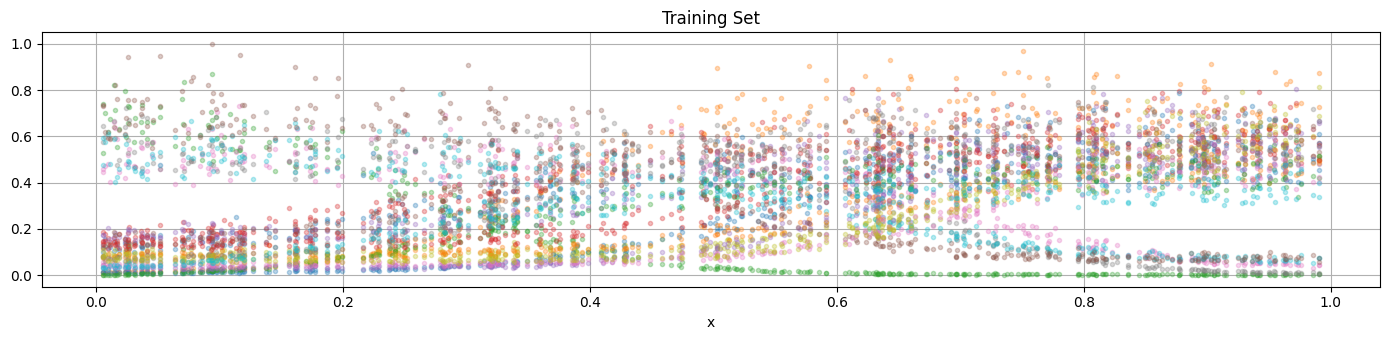

In [22]:
seed, nitems = 42, 20
data_tr = util.generate_costs(nsamples=350, nitems=nitems, seed=seed, noise_scale=.2, noise_type='rayleigh', noise_scale_type='relative')
util.plot_df_cols(data_tr, figsize=figsize, title='Training Set', scatter=True)

The distribution is the same we used for the one-stage problem

## A Practical Example

**Then we generate the remaining problem parameters**

In [23]:
# Generate the problem
rel_req = 0.6
rel_buffer_cost = 10
prb = util.generate_2s_problem(nitems, requirement=rel_req * data_tr.mean().sum(), rel_buffer_cost=rel_buffer_cost, seed=seed)
prb

ProductionProblem2Stage(costs=[1.14981605 1.38028572 1.29279758 1.23946339 1.06240746 1.06239781
 1.02323344 1.34647046 1.240446   1.28322903 1.0082338  1.38796394
 1.33297706 1.08493564 1.07272999 1.0733618  1.1216969  1.20990257
 1.17277801 1.11649166], requirement=3.8862101169088654, buffer_cost=11.830809153591137)

* The minimum value if 60% of the sum of average values on the training data
* Buying in the second stage is 10 times more expensive then the average cost

## A Practical Example

**For testing, we generate multiple samples per instance**

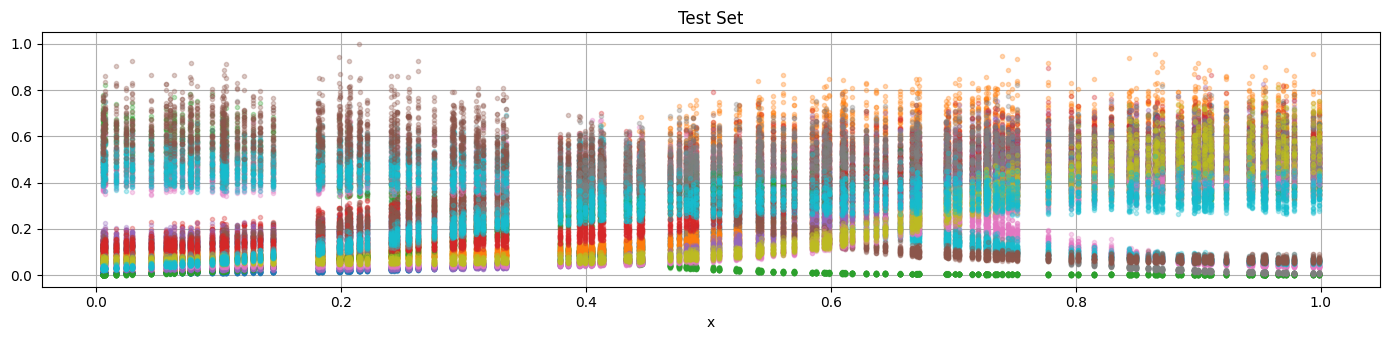

In [24]:
data_ts = util.generate_costs(nsamples=150, nitems=nitems, seed=seed, sampling_seed=seed+1, noise_scale=0.2, noise_type='rayleigh', noise_scale_type='relative', nsamples_per_point=30)
util.plot_df_cols(data_ts, figsize=figsize, title='Test Set', scatter=True)

By doing this, we get a more reliable evaluation of uncertainty

## A PFL Approach

**We start by training a prediction focused approach**

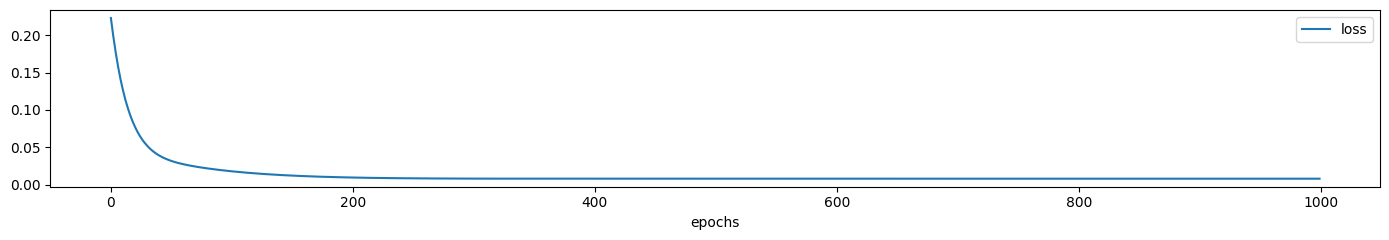

Training time: 6.9677 sec
R2: 0.80, MAE: 0.071, RMSE: 0.09 (training)
R2: 0.75, MAE: 0.071, RMSE: 0.09 (training)


In [25]:
pfl_2s = util.build_ml_model(input_size=1, output_size=nitems, hidden=[], name='pfl_2s', output_activation='linear')
history = util.train_ml_model(pfl_2s, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_scores=False, print_time=True)
util.print_ml_metrics(pfl_2s, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(pfl_2s, data_ts.index.values, data_ts.values, label='training')

This is as fast at inference time as DFL, and can be used for warm-starting

## Evaluating Two-Stage Approaches

**Two-state stochastic approaches can be evaluated in two ways**

We can compare then with _the best we could do_

* The cost different is the proper regret
* Its computation requires solving a 2s-SOP with high accuracy
* ...Making it a very computationally expensive metric

We can compare them with the expected cost of _a clairvoyant approach_

* The cost difference is called Expected Value of Perfect Information
* ...Or sometimes Post-hoc regret
* Its computation requires solving a 2s-SOP _with just a single scenario_
* ...So it's much faster, but only provide an upper bound on true regret

## Evaluating the PFL Approach

**Let's check the EVPF/Post-hoc regret for the PFL Approach**

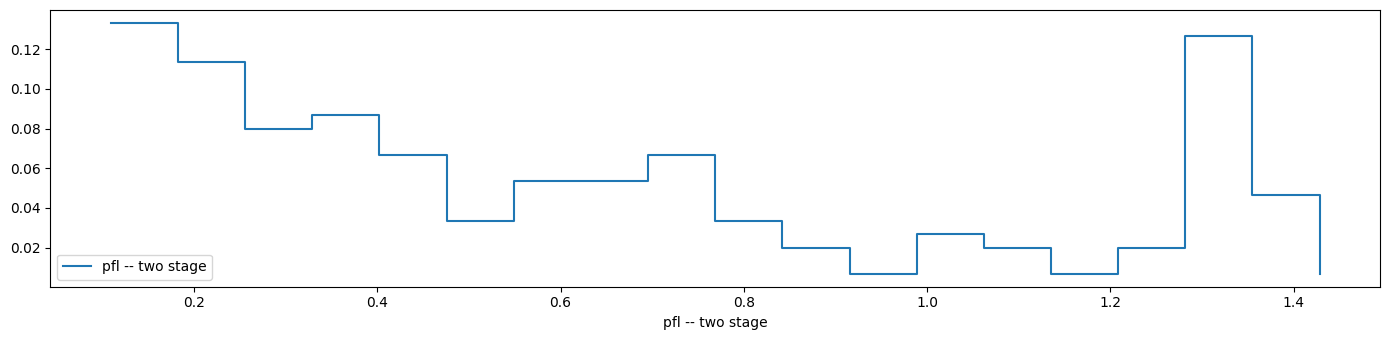

Mean: 0.632 (pfl -- two stage)


In [26]:
pfl_2s_evpf = util.compute_evpf_2s(prb, pfl_2s, data_ts, tlim=10)
util.plot_histogram(pfl_2s_evpf, figsize=figsize, label='pfl -- two stage', print_mean=True)

This will be our baseline

## Training a DFL Approach

**We train a DFL model with warm starting, but no solution cache**

...Since the feasible space for the recourse actions is not fixed

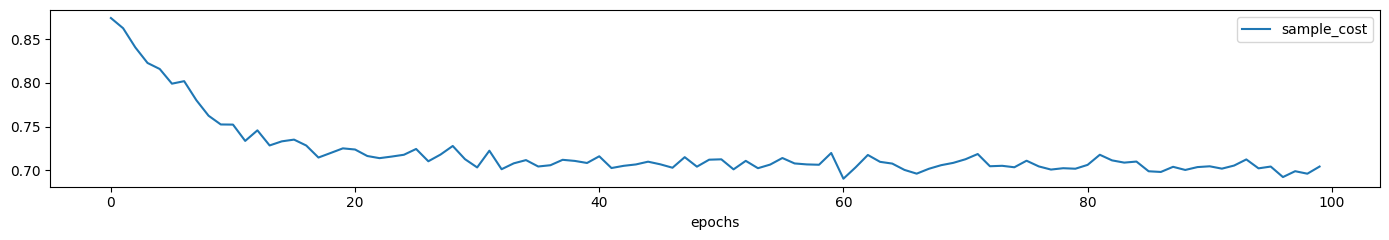

Training time: 131.5764 sec
R2: 0.56, MAE: 0.1, RMSE: 0.13 (training)
R2: 0.64, MAE: 0.082, RMSE: 0.10 (test)


In [27]:
sfge_2s = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[], name='sfge_2s', output_activation='linear', loss_type='regret', sfge=True, sfge_sigma_init=0.10, sfge_sigma_trainable=True, standardize_loss=True)
history = util.train_dfl_model(sfge_2s, data_tr.index.values, data_tr.values, epochs=100, verbose=0, validation_split=0, save_weights=True, load_weights=use_cached_weights, warm_start_pfl=pfl_2s)
util.plot_training_history(history, figsize=figsize_narrow, print_scores=False, print_time=True, excluded_metrics=['sigma', 'loss'])
util.print_ml_metrics(sfge_2s, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(sfge_2s, data_ts.index.values, data_ts.values, label='test')

## Evaluating the DFL Approach

**We can now inspect the EVPF/Post-hoc regret for the DLF approach, as well**

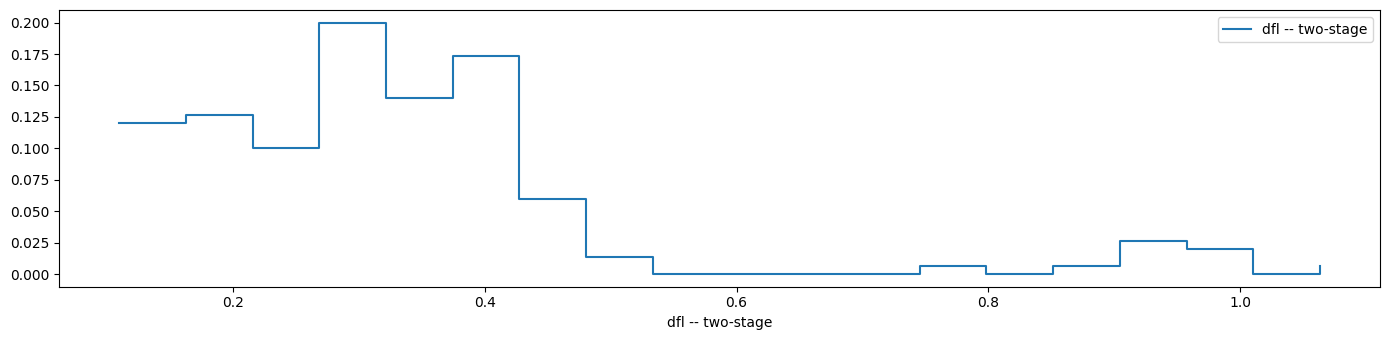

Mean: 0.338 (dfl -- two-stage)


In [28]:
sfge_2s_evpf = util.compute_evpf_2s(prb, sfge_2s, data_ts, tlim=10)
util.plot_histogram(sfge_2s_evpf, figsize=figsize, label='dfl -- two-stage', print_mean=True)

## A More In-depth Comparison

**A more extensive experimentation can be found in [this paper](https://arxiv.org/pdf/2307.05213)**

The method has been tested on:

* Some "normal" DFL benchmarks
* Several two-stage stochastic problems

The baselines are represented by:

* Specialize methods (e.g. SPO, the one from [1]), when applicable
* A neuro-probabilistic model + a scenario based approach

Specialized method tend to work better

* ...But SFGE is much more versatile
* The best results are obtained on 2s-SOPs

## A More In-depth Comparison

**This is how the approach fares again the scenario based method**

...On a problem somewhat similar to our supply planning one

<center><img src="assets/dfl_saa.png" width=65%></center>